<a href="https://colab.research.google.com/github/Sejmou/ml-ex3/blob/master/notebooks/LeNet5_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and Evaluating LeNet-5 on the CIFAR-10 dataset

This notebook documents our attempt at using the LeNet-5 CNN architecture for classification on the CIFAR-10 dataset.

>**Note:** As we didn't always have access to a local machine with Nvidia GPU we used Google Colab's GPU runtimes for fitting LeNet in this notebook. We could not run all the code at once as the Colab GPU runtimes aren't available all the time for regular (free, "non-Pro") users. Unfortunately, after a certain time, Colab instances generally also disconnect - it seems like free users only get limited uninterrupted runtime. 

>This means that we fitted the two models in two separate runs. Therefore, somewere executed twice across different "executions" of the notebooks and the whole code flow is a bit messy. Sorry for any confusion caused by this!

> The logs and model checkpoints for this notebook are available in `model_fit_results/CIFAR-10/LeNet`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # unfortunately, we cannot import our helper scripts directly on Google Colab as other files from our repo are not accessible
  # we have to clone our GitHub repo to fetch the helper scripts and add the script folder of cloned repo to the syspath

  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')

  from google.colab import drive
  drive.mount('/content/drive')
  root_log_dir = f'/content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'#pick drive folder that suits you
else:
  root_log_dir = f'../model_fit_results/CIFAR-10/LeNet/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'

Notebook running on Google Colab
Installing GitPython using pip
cloning our git repo to get helper scripts
cloned successfully
appended helper_scripts module to sys.path
Mounted at /content/drive


## Loading the data

LeNet takes an image of shape 32x32x1 in the input layer (i.e., the images should all be grayscale). Furthermore, the input image intensity values should be normalized. We get the images in the desired format from our data loader:

In [3]:
from helper_scripts.data_loaders import CIFAR10Loader

data_loader = CIFAR10Loader('.data/')

X_train, X_val, X_test, y_train, y_val, y_test = data_loader.get_processed_imgs(target_width=32, target_height=32,
                                                        normalize=True, convert_to_grayscale=True)

Finished downloading required files for CIFAR-10 dataset
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


Let's have a quick look at what the data we got back looks like:

In [4]:
from helper_scripts.data_exploration import print_dataset_summary, show_img

print_dataset_summary(data=(X_train, X_val, X_test, y_train, y_val, y_test), dataset_name='CIFAR-10')


--- Checking loaded CIFAR-10 data ---
Data types
X_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
y_val: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>

Data shapes
X_train: (35000, 32, 32)
X_val: (15000, 32, 32)
X_test: (10000, 32, 32)
y_train: (35000,)
y_val: (15000,)
y_test: (10000,)

Image stats:
shape: (60000, 32, 32)
Max value across all images and channels: 0.9998999999999999
Min value across all images and channels: 0.0
Split sizes:
 train size: 35000
validation size: 15000
test size: 10000
Total dataset size: 60000

Train/Val/Test ratio: 0.58/0.25/0.17
Train/Val ratio:0.7/0.3
(Train+Val)/Test ratio:0.83/0.17


We notice that y_train, y_val, and y_test are in the wrong shape to be used by Keras classifiers. We need to one-hot-encode them:

In [5]:
from tensorflow.keras.utils import to_categorical 

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Let's also have a look at an example image from the train, test, and validation datasets:

In [ ]:
X_train[3].min()

0.10158745098039217

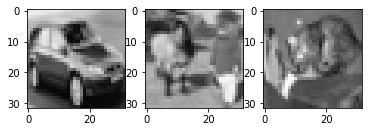

In [ ]:
fig, ax = plt.subplots(1, 3)

for i, split in enumerate([X_train, X_val, X_test]):
  show_img(split[0], ax=ax[i], val_range_min=0, val_range_max=1)

Finally, let's remind ourselves what classes the dataset contains:

In [ ]:
data_loader.text_label_dict

{0: 'Airplane',
 1: 'Automobile',
 2: 'Bird',
 3: 'Cat',
 4: 'Deer',
 5: 'Dog',
 6: 'Frog',
 7: 'Horse',
 8: 'Ship',
 9: 'Truck'}

## Defining the Model (based on [this](https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086)):

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import AveragePooling2D

def LeNetModel(num_classes):
  model = Sequential()

  model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D())

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(units=120, activation='relu'))

  model.add(Dense(units=84, activation='relu'))

  model.add(Dense(units=num_classes, activation = 'softmax'))
  return model

### Fitting w/o Data Augmentation:

In [12]:
loss = 'binary_crossentropy' 
optimizer = 'sgd'
num_classes = data_loader.number_of_classes

model = LeNetModel(num_classes)
model.compile(loss=loss , optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [18]:
epochs = 300
batch_size=32

#### Adding callbacks

We will use three callbacks: one for storing the best model weights, one custom callback for measuring the fit time, and one for logging the training process to TensorBoard.

In [7]:
from keras.callbacks import ModelCheckpoint

log_dir = os.path.join(root_log_dir, 'no_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)




In [8]:
from helper_scripts.deep_learning import TimeHistory
time_cb = TimeHistory()

In [9]:
from keras.callbacks import TensorBoard

tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data= (X_val, y_val),
    callbacks=[checkpoint_cb, time_cb, tensorboard_cb]
)

Epoch 1/300
1094/1094 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.1361
Epoch 1: val_accuracy improved from -inf to 0.16860, saving model to /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
1094/1094 [==============================] - 20s 6ms/step - loss: 0.3666 - accuracy: 0.1361 - val_loss: 0.3250 - val_accuracy: 0.1686
Epoch 2/300
1085/1094 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.1727
Epoch 2: val_accuracy improved from 0.16860 to 0.18273, saving model to /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
1094/1094 [==============================] - 6s 6ms/step - loss: 0.3234 - accuracy: 0.1730 - val_loss: 0.3218 - val_accuracy: 0.1827
Epoch 3/300
1093/1094 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.1818
Epoch 3: val_accuracy did not improve from 0.18273
1094/1094 [=========================

In [ ]:
import time

time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

Total fit time was 00:35:36


In [ ]:
# load optimal model
model.load_weights(checkpoint_path)

scores = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.2226 - accuracy: 0.5124


As we can see, the LeNet model whose weights were learned from on our training and validation data over 300 epochs reaches a test set accuracy of roughly 51%. The prediction was done within a second.

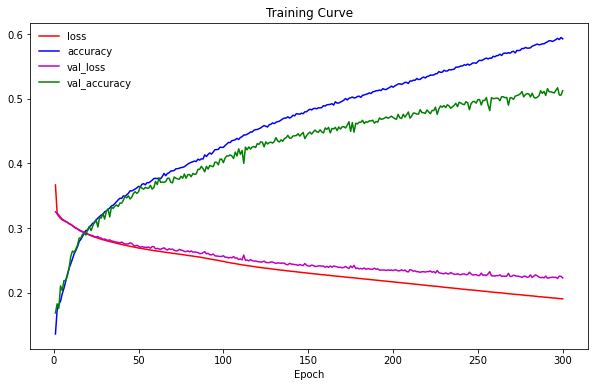

In [ ]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)
model.save(os.path.join(log_dir, 'Model.h5'))

### Fitting with Data Augmentation:

We can use Keras' `ImageDataGenerator`:

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
np.random.seed(0)

In [13]:
loss = 'binary_crossentropy' 
optimizer = 'sgd'
num_classes = data_loader.number_of_classes

model = LeNetModel(num_classes)
model.compile(loss=loss , optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [14]:
log_dir = os.path.join(root_log_dir, 'with_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [21]:
time_cb = TimeHistory()

In [16]:
tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [19]:
history = model.fit(datagen.flow(
                        X_train.reshape(*X_train.shape, 1),# need to add fourth dimension of 1 apparently
                        y_train, batch_size=batch_size),
                    validation_data= (X_val, y_val),
                    workers=4,
                    epochs=epochs, callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

Epoch 1/300
1090/1094 [============================>.] - ETA: 0s - loss: 0.3697 - accuracy: 0.1207
Epoch 1: val_accuracy improved from -inf to 0.12473, saving model to /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_10_14_46/with_augmentation/best_val_acc_weights.h5
1094/1094 [==============================] - 41s 28ms/step - loss: 0.3695 - accuracy: 0.1207 - val_loss: 0.3267 - val_accuracy: 0.1247
Epoch 2/300
1092/1094 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.1425
Epoch 2: val_accuracy improved from 0.12473 to 0.16220, saving model to /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_10_14_46/with_augmentation/best_val_acc_weights.h5
1094/1094 [==============================] - 32s 29ms/step - loss: 0.3264 - accuracy: 0.1425 - val_loss: 0.3245 - val_accuracy: 0.1622
Epoch 3/300
1094/1094 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.1559
Epoch 3: val_accuracy improved from 0.16220 to 0.17467, saving model to /conte

In [22]:
time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

AttributeError: ignored

In [23]:
# load optimal model
model.load_weights(checkpoint_path)

scores = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.2376 - accuracy: 0.4559


In [25]:
from helper_scripts.deep_learning import plot_loss_and_acc

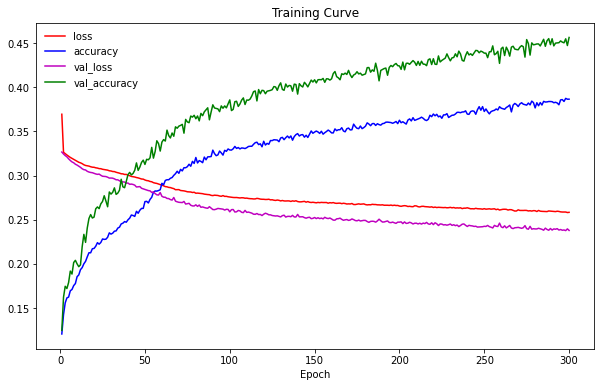

In [29]:
plot_loss_and_acc(history.history, epochs=epochs)
model.save(os.path.join(log_dir, 'Model.h5'))

A rough estimate for the fit time can however be made:

In [31]:
import time

fit_time_estimate_secs = 300 * 38 #epochs * average runtime per epoch
print(f'estimated fit time for 300 epochs was {time.strftime("%H:%M:%S", time.gmtime(fit_time_estimate_secs))}')

estimated fit time for 300 epochs was 03:10:00


We notice that the test set accuracy (45%) is lower than for the model without data augmentation. This comes as a bit of a surprise.

## Plotting confusion matrices

Finally, let's also have a look at the confusion matrices for the test set predictions of the trained LeNet models, both with and without data augmention:

### LeNet (no data augmentation)

We also have to load this model from the respective checkpoint file first as our runtime disconnected in the meantime. Let's try to find it:

We can see from the model.fit() logs for the "no-augmentation" model above, that the best model checkpoint should be stored in `/content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5`

In [ ]:
!ls /content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation

best_val_acc_weights.h5  fit_times.csv	Model.h5  tensorboard


Looks good!

In [32]:
log_dir_no_aug = '/content/drive/MyDrive/ml-ex3/CIFAR-10/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5'

In [ ]:
# Recreate the best model from the fit on augmented data, including its weights and the optimizer
no_aug_model = tf.keras.models.load_model(log_dir_no_aug)

# Show the model architecture
no_aug_model.summary()

In [ ]:
no_aug_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.2315 - accuracy: 0.5096


[0.23150719702243805, 0.5095999836921692]

In [ ]:
from helper_scripts.model_evaluation import plot_confusion_matrix

In [ ]:
import numpy as np
y_preds_no_aug = no_aug_model.predict(X_test)# matrix; row: observation, col: prob. for class
y_pred_no_aug = np.argmax(y_preds_no_aug, axis=1)

In [ ]:
text_labels = list(data_loader.text_label_dict.values())
text_labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
y_test_1d = np.argmax(y_test, axis=1)# for plotting confusion matrix, we need class labels as 1d array

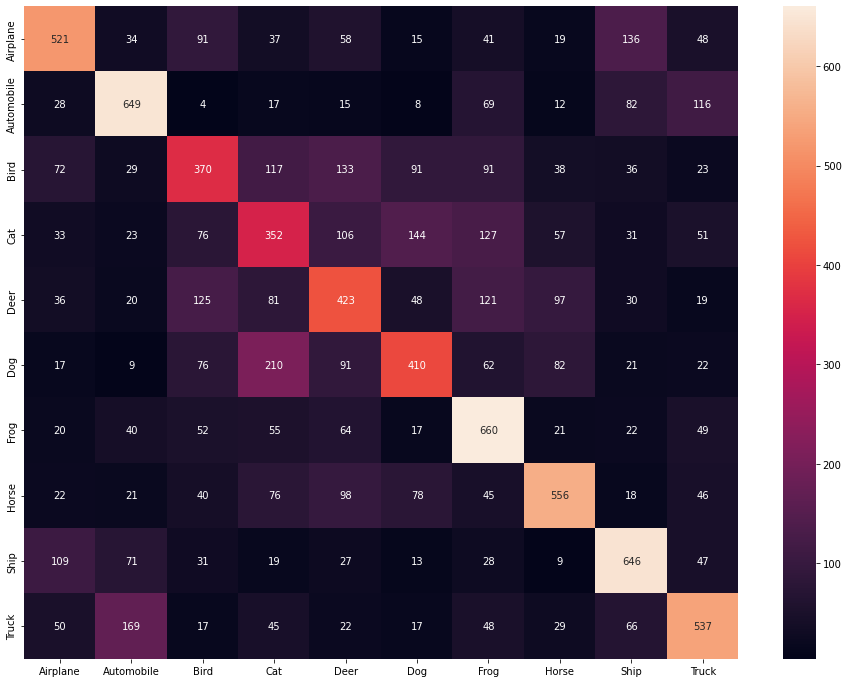

In [ ]:
from helper_scripts.model_evaluation import plot_confusion_matrix

plot_confusion_matrix(y_test_1d, y_pred_no_aug, text_labels=text_labels)

### LeNet (with data augmentation)

In [ ]:
y_preds_with_aug = aug_model.predict(X_test)
y_pred_with_aug = np.argmax(y_preds_with_aug, axis=1)

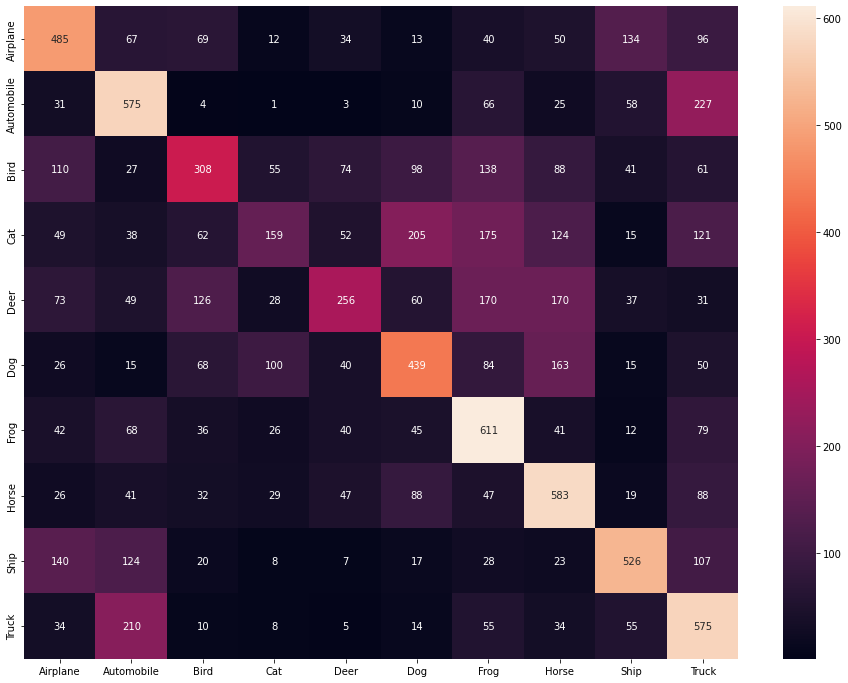

In [ ]:
plot_confusion_matrix(y_test_1d, y_pred_with_aug, text_labels=text_labels)